In [14]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
from mne_icalabel import label_components

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *
from ERP_utils import * 


In [27]:
task = 'error'
period = 'pre'  
erp_begin = -0.5
erp_end = 0.5
erp_window = '_n05to05'

subjects_to_process = ['13']
bad_chs_sub = ['PO7', 'O1', 'Iz', 'P8', 'P10', 'TP8']

overwrite = False
keystroke_trigs = 'audio'

In [28]:
ch_names_64, _ = load_channels()


In [29]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
evokeds_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data{erp_window}'
epochs_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data{erp_window}'

ch_names_64, ch_names_72 = load_channels()
"""ref_names = ['M1', 'M2']
eog_names = ['EOG1', 'EOG2']"""

downfreq = 128

#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_{task}_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    all_electrodes = data['all_electrodes']
    events_sv = data['events']

    

Opening eeg_error_pre_13.mat


In [30]:
#making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})

raw.set_montage('biosemi64')

Creating RawArray with float64 data, n_channels=72, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_61466/3214231580.py:6: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_61466/3214231580.py:7: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 76800 (600.0 s), ~42.3 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


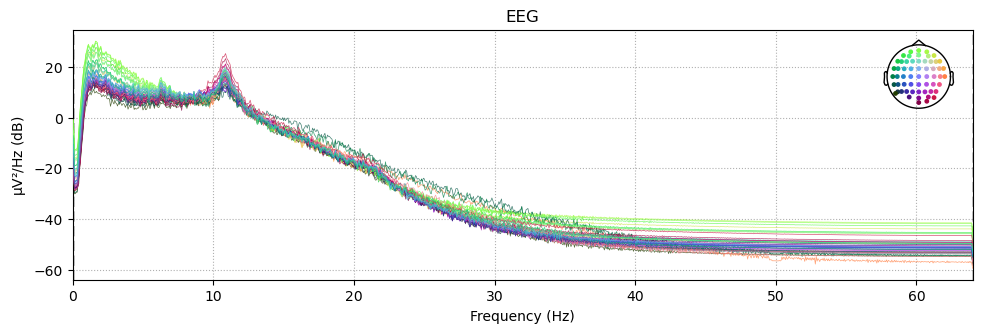

In [31]:
raw.info['bads'] = bad_chs_sub
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

Fitting ICA to data using 58 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_61466/676616455.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 58 components
Fitting ICA took 304.2s.


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


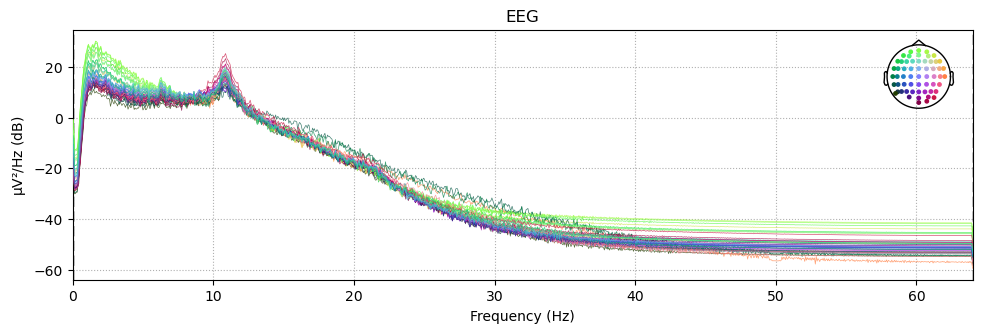

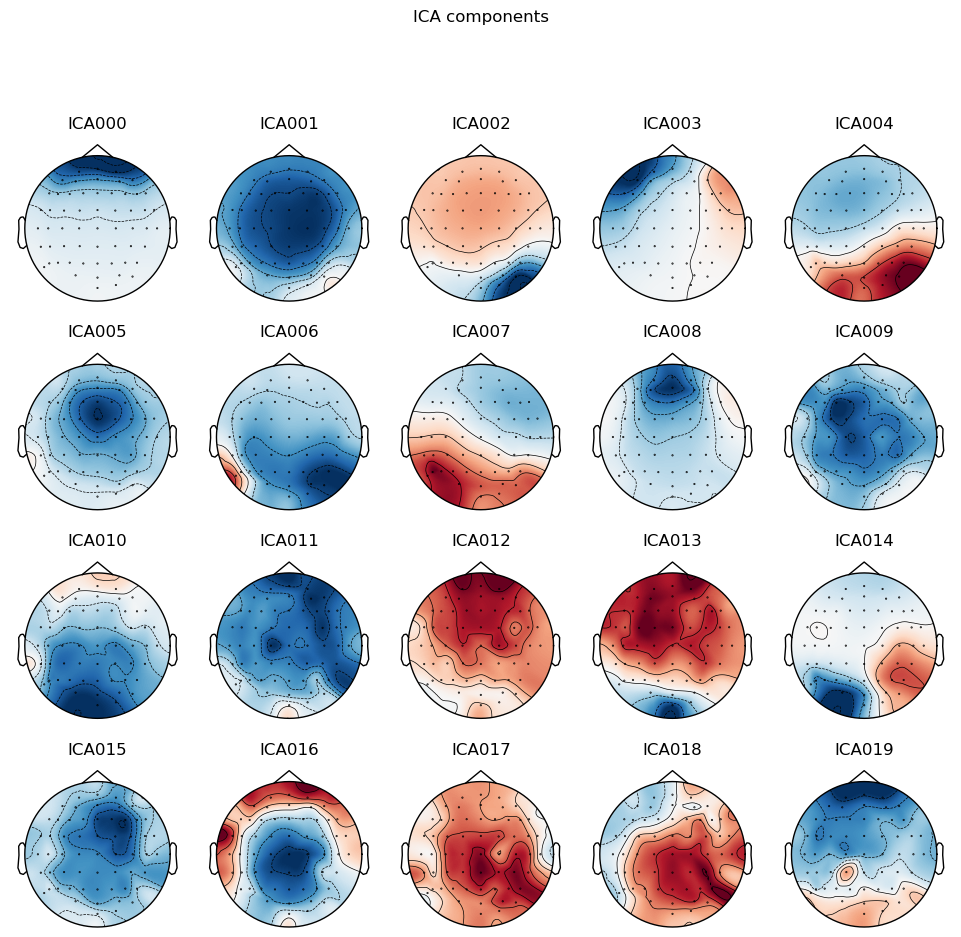

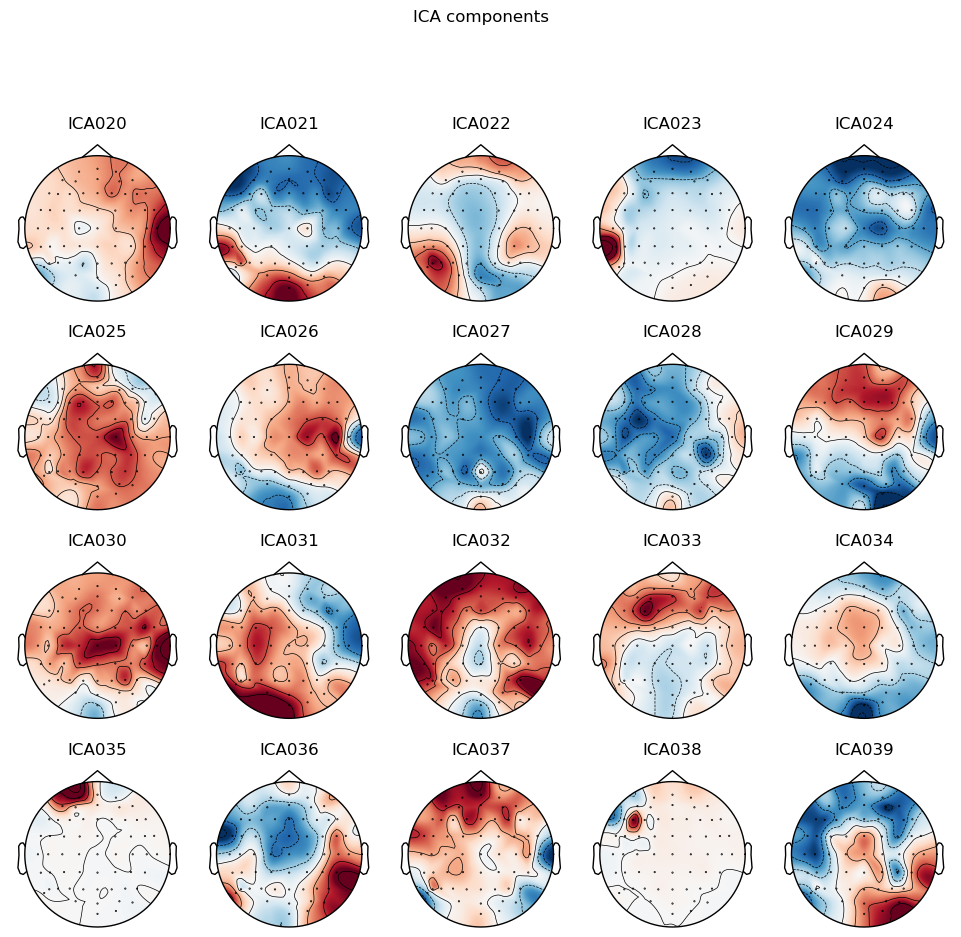

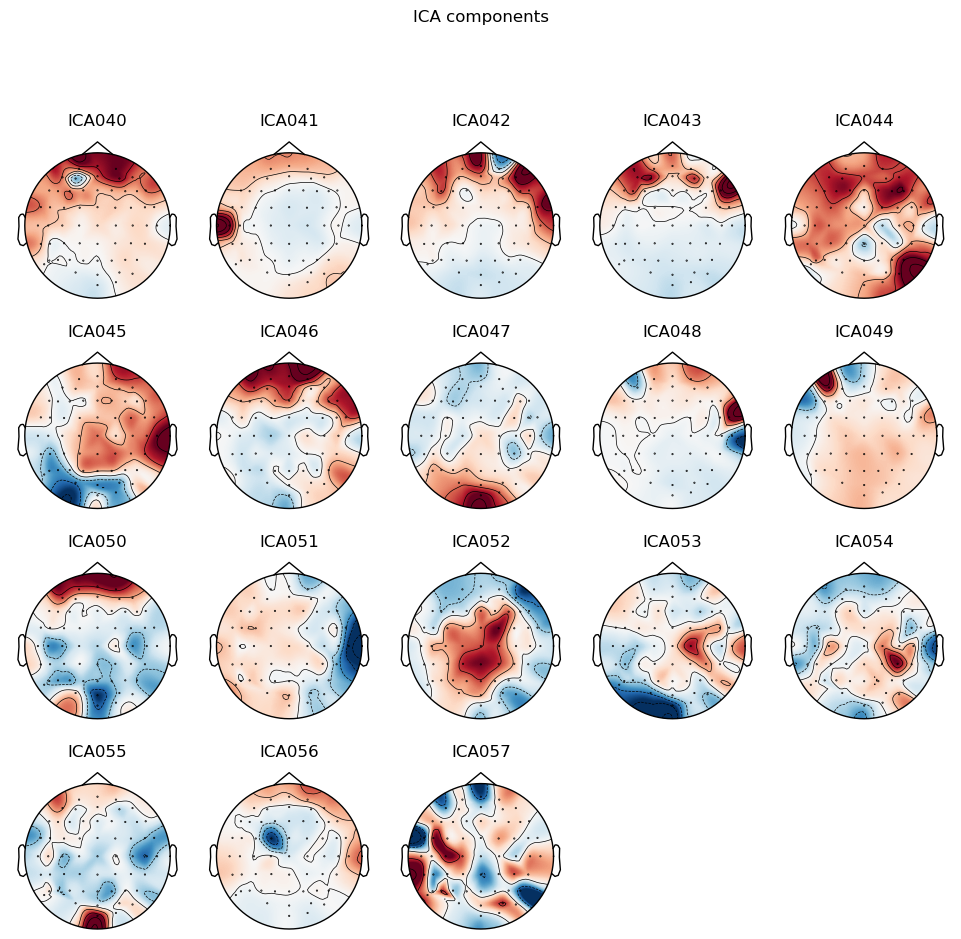

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 18 Axes>]

In [32]:
ica = ICA(max_iter='auto', random_state=97)
ica.fit(raw)

ica.plot_components()

In [33]:
#exclude components based on correlation to eog
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

#manually select components if eog not available
#ica.exclude = [0, 3]

#reconstruct raw
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Using EOG channels: LO1, LO2


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 72 x 76800 (600.0 s), ~42.3 MB, data loaded>

In [34]:
events_arr = make_raw_events(events_sv)

In [35]:
events_arr

array([[   59,     0,     2],
       [  167,     0,     2],
       [  459,     0,     2],
       ...,
       [76541,     0,     6],
       [76636,     0,     6],
       [76732,     0,     6]])

Not setting metadata
399 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 399 events and 129 original time points ...
1 bad epochs dropped
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
199 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 199 events and 129 original time points ...
0 bad epochs dropped
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


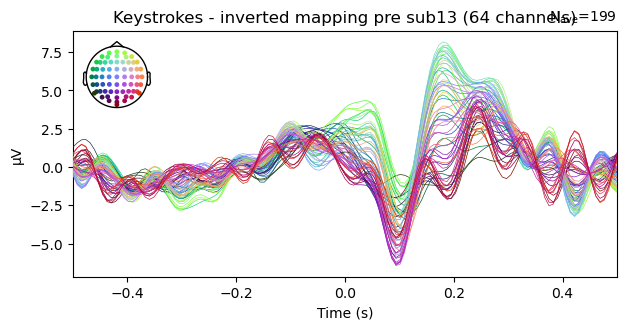

Not setting metadata
100 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 129 original time points ...
0 bad epochs dropped
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


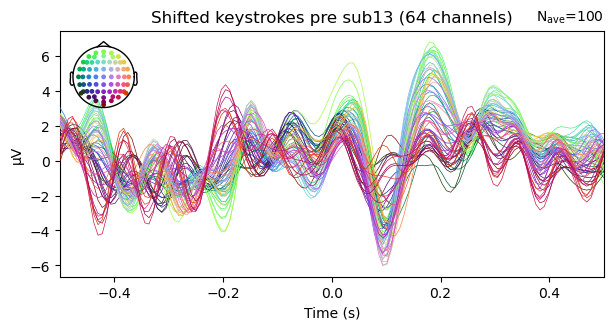

Not setting metadata
100 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 129 original time points ...
1 bad epochs dropped
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


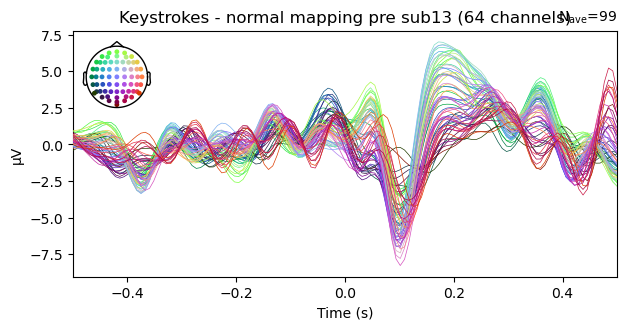

In [36]:
#              SEGMENT INTO EPOCHS
#--------------------------------------------



plot = True
#--------------------------------------------
#               SET UP TRIGGERS
#--------------------------------------------
events_arr = make_raw_events(events_sv)

if keystroke_trigs == 'MIDI':
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==6])
else:
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])


t_inv = clean_triggers(events_arr[events_arr[:, 2]==3])
t_shinv = clean_triggers(events_arr[events_arr[:, 2]==4])
t_norm = clean_triggers(events_arr[events_arr[:, 2]==5])
t_modeswitch = np.concatenate([t_inv, t_shinv, t_norm])
t_modeswitch = events_inorder(t_modeswitch)

#--------------------------------------------
#               SET UP EVOKEDS OBJECTS
#--------------------------------------------
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
epochs = epochs.copy().interpolate_bads(reset_bads = True)
evoked = epochs.average()

#keystrokes in the inverted mapping
inv_sections = find_sections(reconst_raw, t_inv, t_modeswitch)
inv_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, inv_sections)
epochs_inv = mne.Epochs(reconst_raw, inv_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
epochs_inv = epochs_inv.copy().interpolate_bads(reset_bads = True)
inv_evoked = epochs_inv.average()
if plot:
    fig = inv_evoked.plot(titles = f'Keystrokes - inverted mapping {period} sub{subject_ID}')

#keystrokes in shinv mapping
shinv_sections = find_sections(reconst_raw, t_shinv, t_modeswitch)
shinv_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, shinv_sections)
epochs_shinv = mne.Epochs(reconst_raw, shinv_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
epochs_shinv = epochs_shinv.copy().interpolate_bads(reset_bads = True)
shinv_evoked = epochs_shinv.average()
if plot:
    fig = shinv_evoked.plot(titles = f'Shifted keystrokes {period} sub{subject_ID}')

#keystrokes in normal mapping
norm_sections = find_sections(reconst_raw, t_norm, t_modeswitch)
norm_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, norm_sections)
epochs_norm = mne.Epochs(reconst_raw, norm_keystrokes, tmin=erp_begin, tmax=erp_end, preload=True)
epochs_norm = epochs_norm.copy().interpolate_bads(reset_bads = True)
norm_evoked = epochs_norm.average()
if plot:
    fig = norm_evoked.plot(titles = f'Keystrokes - normal mapping {period} sub{subject_ID}')


In [37]:
overwrite = True

#--------------------------------------------
#         SAVE DATA
#--------------------------------------------
#ERPs
mne.write_evokeds(f'{evokeds_folder}/error_ERP_all_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
mne.write_evokeds(f'{evokeds_folder}/error_ERP_inv_{period}_{subject_ID}.fif', inv_evoked, overwrite = overwrite)
mne.write_evokeds(f'{evokeds_folder}/error_ERP_shinv_{period}_{subject_ID}.fif', shinv_evoked, overwrite = overwrite)
mne.write_evokeds(f'{evokeds_folder}/error_ERP_norm_{period}_{subject_ID}.fif', norm_evoked, overwrite = overwrite)

#epochs
epochs.save(f'{epochs_folder}/error_epochs_all_{period}_{subject_ID}.fif', overwrite = overwrite)
epochs_inv.save(f'{epochs_folder}/error_epochs_inv_{period}_{subject_ID}.fif', overwrite = overwrite)
epochs_shinv.save(f'{epochs_folder}/error_epochs_shinv_{period}_{subject_ID}.fif', overwrite = overwrite)
epochs_norm.save(f'{epochs_folder}/error_epochs_norm_{period}_{subject_ID}.fif', overwrite = overwrite)








Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_61466/459284252.py:7: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data_n05to05/error_ERP_all_pre_13.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(f'{evokeds_folder}/error_ERP_all_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_61466/459284252.py:8: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data_n05to05/error_ERP_inv_pre_13.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(f'{evokeds_folder}/error_ERP_inv_{period}_{subject_ID}.fif', inv_evoked, overwrite = overwrite)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_614